<a href="https://colab.research.google.com/github/tarunc27/TCS-Stock-Price-Analysis-and-Prediction/blob/main/TCS_data_stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Step 2: Mount Google Drive (to access dataset)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 3: Load Dataset
# Option 1: Load from Google Drive (update path to your file)
try:
    data = pd.read_csv('/content/drive/MyDrive/Internship/TCS Stock Data - Live and Latest/TCS_stock_history.csv')  # Adjust path
except FileNotFoundError:
    # Option 2: Fetch TCS stock data using yfinance if file not found
    print("Dataset not found. Fetching TCS stock data using yfinance...")
    !pip install yfinance
    import yfinance as yf
    data = yf.download('TCS.NS', start='2002-08-12', end='2023-12-31')
    data.reset_index(inplace=True)
    # Rename columns to match expected format
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']]

# Convert Date to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by='Date', inplace=True)


In [ ]:
# Step 4: Data Preprocessing
# Check for null values
print("Null Values Before Preprocessing:\n", data.isnull().sum())

# Convert price columns to numeric
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)  # Drop any remaining NaN rows

# Verify no null values
print("\nNull Values After Preprocessing:\n", data.isnull().sum())


Null Values Before Preprocessing:
 Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Null Values After Preprocessing:
 Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


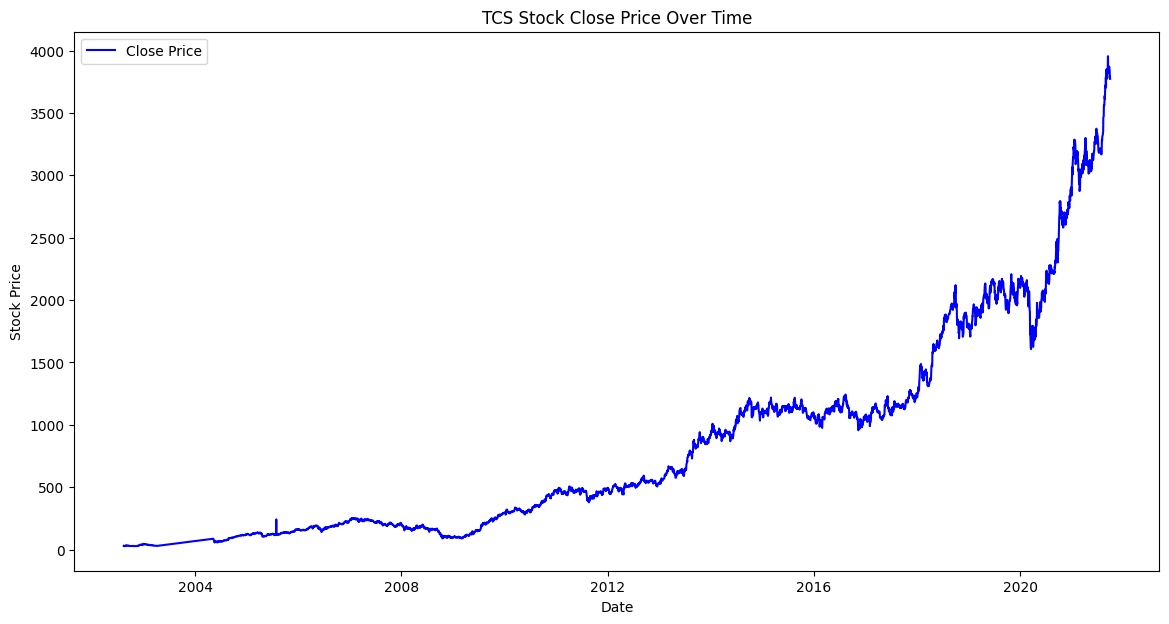

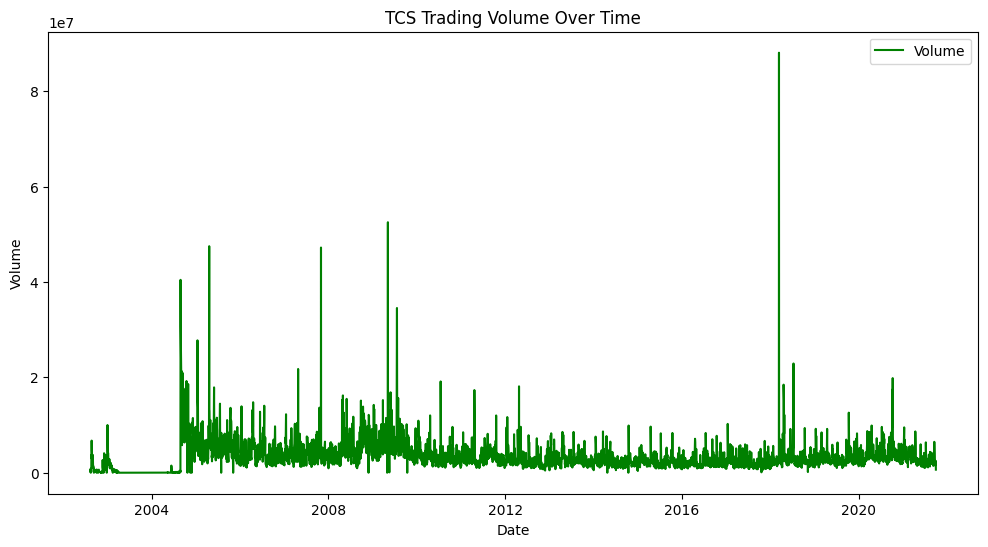

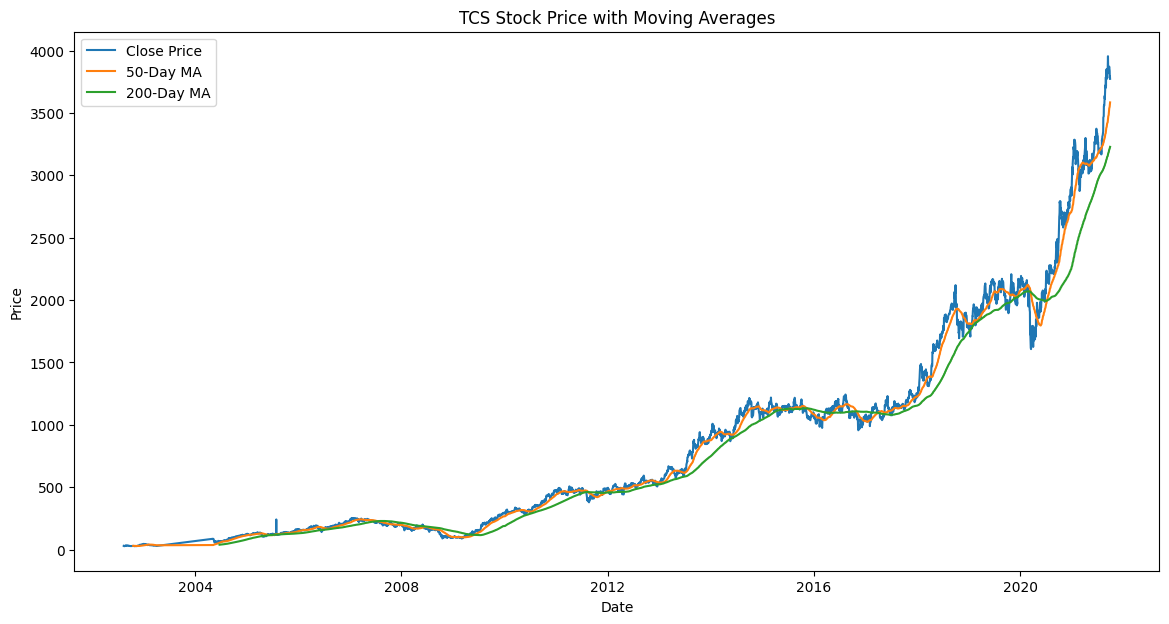

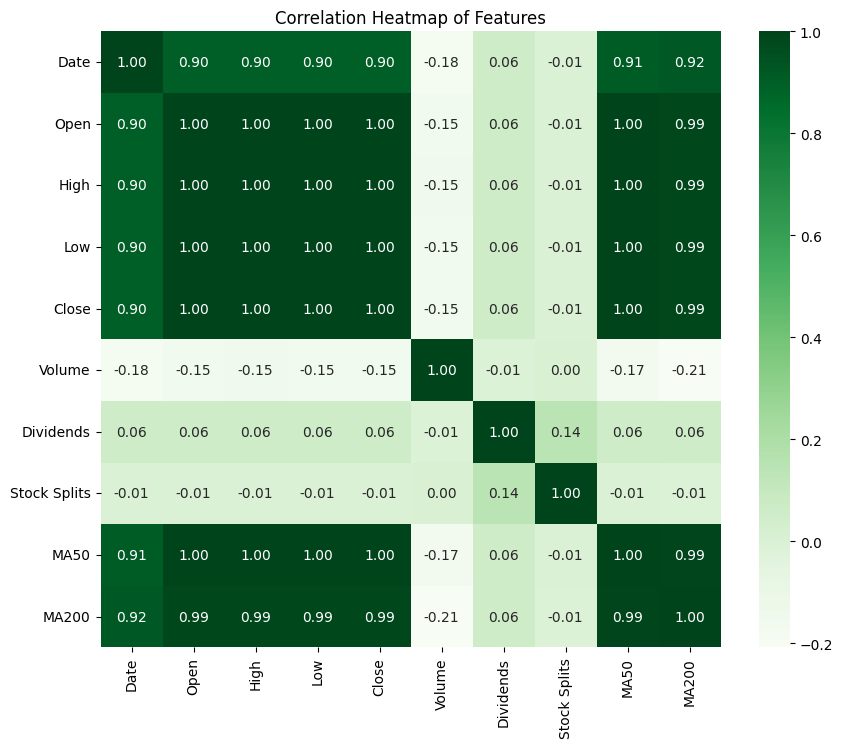


Correlation with Close Price:
 Close           1.000000
High            0.999914
Low             0.999901
Open            0.999787
MA50            0.996965
MA200           0.989252
Date            0.899214
Dividends       0.060179
Stock Splits   -0.006635
Volume         -0.152844
Name: Close, dtype: float64


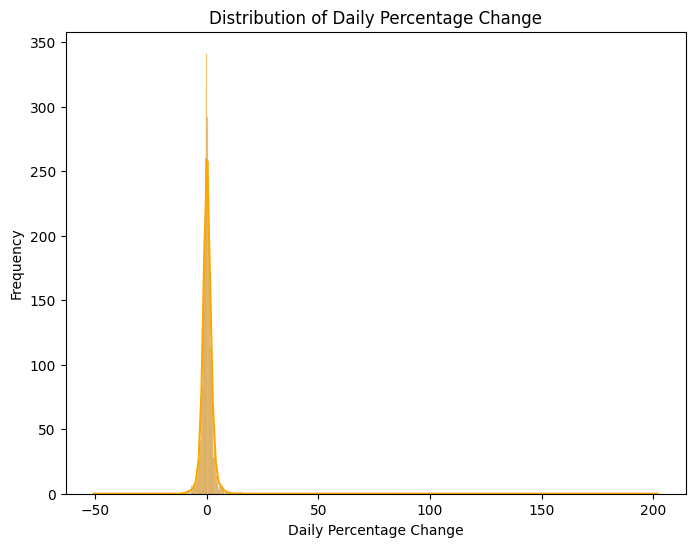

In [ ]:
# Step 5: Exploratory Data Analysis (EDA)
# Plot Close Price Over Time
plt.figure(figsize=(14,7))
plt.plot(data['Date'], data['Close'], color='blue', label='Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TCS Stock Close Price Over Time')
plt.legend()
plt.savefig('close_price.png')
plt.show()

# Plot Trading Volume
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Volume'], label='Volume', color='green')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('TCS Trading Volume Over Time')
plt.legend()
plt.savefig('volume.png')
plt.show()

# Calculate and Plot Moving Averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
plt.figure(figsize=(14,7))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['MA50'], label='50-Day MA')
plt.plot(data['Date'], data['MA200'], label='200-Day MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TCS Stock Price with Moving Averages')
plt.legend()
plt.savefig('moving_averages.png')
plt.show()

# Correlation Heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.savefig('correlation_heatmap.png')
plt.show()
print("\nCorrelation with Close Price:\n", correlation_matrix['Close'].sort_values(ascending=False))

# Daily Price Change Distribution
data['Daily_Price_Change'] = data['Close'].pct_change() * 100
plt.figure(figsize=(8,6))
sns.histplot(data['Daily_Price_Change'].dropna(), kde=True, color='orange')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Percentage Change')
plt.savefig('daily_change.png')
plt.show()


In [ ]:
# Step 6: Feature Engineering
# Extract Date Features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Day_of_Week'] = data['Date'].dt.dayofweek

# Lag Feature (Previous Day's Close)
data['Prev_Close'] = data['Close'].shift(1)

# Moving Average Feature
data['Moving_Avg_Close'] = data['Close'].rolling(window=7).mean()
data.dropna(inplace=True)  # Drop rows with NaN values




Linear Regression Results:
Mean Squared Error: 39.04992998573584
R-Squared Score: 0.9999438356582185
Mean Absolute Error: 3.8579699841833577


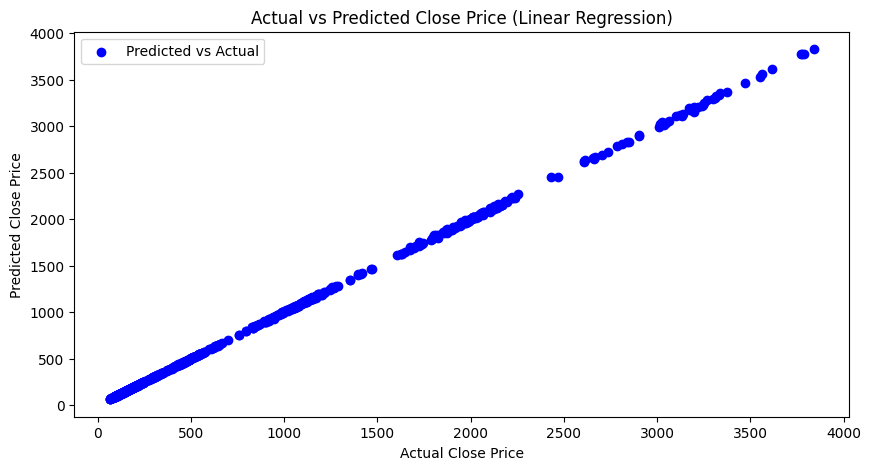

In [ ]:
# Step 7: Linear Regression Model
# Prepare Features and Target
X = data[['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']]
y = data['Close']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_rf = X_test.copy()
y_test_rf = y_test.copy()

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make Predictions
y_pred = lr_model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("\nLinear Regression Results:")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Visualize Predictions
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price (Linear Regression)')
plt.legend()
plt.savefig('lr_predictions.png')
plt.show()

# Save Model
import pickle
with open('TCS_Stock_Predictor.pkl', 'wb') as file:
    pickle.dump(lr_model, file)



100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


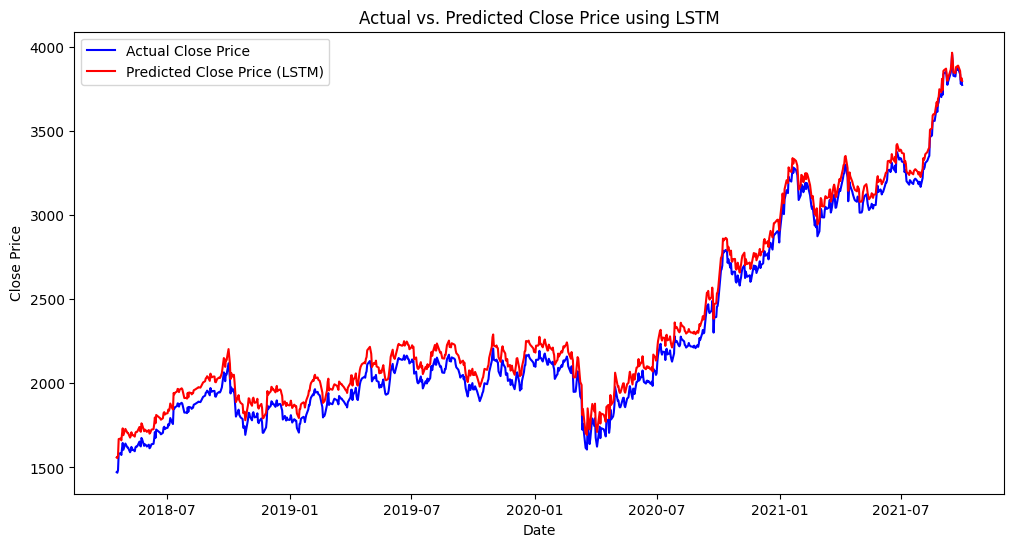


LSTM Results:
LSTM Mean Absolute Error: 77.37519700314517


In [ ]:
# Step 8: LSTM Model
# Prepare Data for LSTM
X_train_lstm = data['Close'].values.reshape(-1, 1)
y_train_lstm = data['Close'].shift(-1).dropna().values

# Normalize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_lstm)

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_scaled[:-1].reshape(-1, 1, 1)
y_train_lstm = X_train_scaled[1:]

# Prepare Test Data
test_ratio = 0.2
test_size = int(len(data) * test_ratio)
test_data = data[-test_size:]
X_test = test_data['Close'].values.reshape(-1, 1)
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape(-1, 1, 1)

# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM Model
epochs = 30
batch_size = 15
for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train_lstm), batch_size):
        X_batch = X_train_lstm[i:i+batch_size]
        y_batch = y_train_lstm[i:i+batch_size]
        lstm_model.train_on_batch(X_batch, y_batch)

# Make LSTM Predictions
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

# Visualize LSTM Predictions
plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close Price', color='b')
plt.plot(test_data['Date'], lstm_predictions, label='Predicted Close Price (LSTM)', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price using LSTM')
plt.legend()
plt.savefig('lstm_predictions.png')
plt.show()

# Evaluate LSTM Model
lstm_mae = mean_absolute_error(test_data['Close'], lstm_predictions)
print("\nLSTM Results:")
print(f"LSTM Mean Absolute Error: {lstm_mae}")

# Save LSTM Predictions
predictions_df = pd.DataFrame({
    'Date': test_data['Date'],
    'Predicted_Close': lstm_predictions
})
predictions_df.to_csv('lstm_predictions.csv', index=False)


In [ ]:
# Step 9: Future Work (Example: Random Forest)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test_rf)
rf_mse = mean_squared_error(y_test_rf, rf_pred)

print("\nRandom Forest Results:")
print(f"Random Forest MSE: {rf_mse}")

# Save Notebook Outputs
print("\nAll outputs saved: plots and predictions CSV.")


Random Forest Results:
Random Forest MSE: 98.58865670255221

All outputs saved: plots and predictions CSV.
